# Project 5: Vehicle Detection and Tracking

### In this project we look to detect and track vehicles from video by training a linear support classifier on a concatenated feature vector of binned spatial features, color histogram features, and histogram of oriented gradient features.

The spatial features are simply a resized video frame to 32x32 pixels, and is then flattened.
The color histogram features are simply a 3 channel concatenated vector of a 32 bin histogram
The histogram of oriented gradients (HOG) features, which is a 5 step algorithm operating on the first order image gradients

In [1]:
# Import all the things
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.measurements import label
%matplotlib inline

import time
import pickle
import glob
from random import randint
from moviepy.editor import VideoFileClip

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

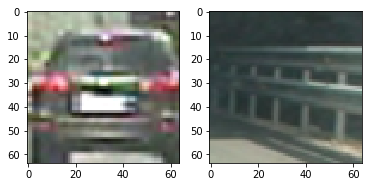

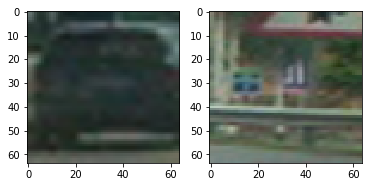

In [2]:
# Load and check the Udacity and GTI training sets 
imgs_test = glob.glob('test_images/*.jpg')

# Load Vehicle Images
c_GTIfar = glob.glob('test_images/vehicles/GTI_Far/*.png')
c_GTIleft = glob.glob('test_images/vehicles/GTI_Left/*.png')
c_GTIright = glob.glob('test_images/vehicles/GTI_MiddleClose/*.png')
c_GTImiddleclose = glob.glob('test_images/vehicles/GTI_Right/*.png')
c_KITTI = glob.glob('test_images/vehicles/KITTI_extracted/*.png')
car_images = c_GTIfar + c_GTIleft + c_GTIright + c_GTImiddleclose + c_KITTI
imgs_veh = car_images


# Load Non Vehicle Images
nc_GTI = glob.glob('test_images/non-vehicles/GTI/*.png')
nc_extras = glob.glob('test_images/non-vehicles/Extras/*.png')
notcar_images = nc_GTI + nc_extras
imgs_non_veh = notcar_images



# Read in cars and notcars
cars    = []
notcars = []

for img in car_images:
    cars.append(img)

for img in notcar_images:
    notcars.append(img) 
   
# Test to make sure that the test images are loading properly
f1,(ax1,ax2)=plt.subplots(1,2,figsize=(6,6))
# Test to make sure that the vehicle images are loading properly
ax1.imshow(mpimg.imread(cars[randint(0,200)]))
# Test to make sure that the non-vehicle images are loading properly
ax2.imshow(mpimg.imread(notcars[randint(0,200)]))

# Test to make sure that the test images are loading properly
f2,(ax1,ax2)=plt.subplots(1,2,figsize=(6,6))
# Test to make sure that the vehicle images are loading properly
ax1.imshow(mpimg.imread(cars[randint(0,200)]))
# Test to make sure that the non-vehicle images are loading properly
ax2.imshow(mpimg.imread(notcars[randint(0,200)]))


In [3]:
# Let's look at the data sets and make sure they aren't biased

print('Total Vehicle Images:',len(cars))
print('Total Non-Vehicle Images:',len(notcars))

print('Vehicles Images Size:',np.shape(cars))
print('Non-Vehicle Images Size:',np.shape(notcars))

print('Total Test Images:',len(imgs_test))
print('Test Images Size:',np.shape(imgs_test))

Total Vehicle Images: 8792
Total Non-Vehicle Images: 8968
Vehicles Images Size: (8792,)
Non-Vehicle Images Size: (8968,)
Total Test Images: 6
Test Images Size: (6,)


In [4]:
### load helper functions ###

#### from vehicle detection and tracking . 16
# Define a function to compute binned color features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)   
    # Use cv2.resize().ravel() to create the feature vector (just flattened image)
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


#### from vehicle detection and tracking . 15, modified to plot with custom ax
def plot3d_custom_ax(ax, pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)


    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation


#### from vehicle detection and tracking . 15
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

### from vehicle detection and tracking . 12
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### from vehicle detection and tracking . 19
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

# from advanced lane finding . 22
def sobel_mag(img_rgb,sobel_kernel,threshmag_min =  20,threshmag_max = 120):  
    # SOBEL: Magnitude
    gray    = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelmx = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    sobelmy = cv2.Sobel(gray,cv2.CV_64F, 0, 1)
    mag_sobel    = np.sqrt(sobelmx**2 + sobelmx**2)
    scaled_sobel = np.uint8(mag_sobel*255/np.max(mag_sobel))
    sobel_mag    = np.zeros_like(scaled_sobel)
    sobel_mag[(scaled_sobel>=threshmag_min) & (scaled_sobel<=threshmag_max) ]=1
    return sobel_mag

### from vehicle detection and tracking . 20
# HOG Features
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### from vehicle detection and tracking . 22 with mods to incorporate hog features
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256),
                     hog_orient=9, hog_pixpcell=8, hog_cellpblock=2,hog_ch='ALL',
                     add_spatial = False, add_hist = False, add_HOG = False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        features_file = []
        # Read in each one by one
        image = mpimg.imread(file)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)    
        else: 
            feature_image = np.copy(image)      
        if(add_spatial):
            spatial_features = []
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            features_file.append(spatial_features)
        if(add_hist):
            hist_features = []
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            features_file.append(hist_features)
        if(add_HOG):
            if hog_ch == 'ALL':
                hog_feat = []
                for channel in range(feature_image.shape[2]):
                    hog_feat.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_feat = get_hog_features(feature_image[:,:,hog_ch], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            features_file.append(hog_feat)
        features.append(np.concatenate(features_file))
    # Return list of feature vectors
    return features


def test_bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

def test_sobel_absx(img,sobel_kernel,threshx_min=20,threshx_max=80):
    # SOBEL: Directional X 
    img_dx     = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_absx   = np.absolute(img_dx)
    img_sobelx = np.uint8(255*img_absx/np.max(img_absx))
    sobel_dirx = np.zeros_like(img_sobelx)
    sobel_dirx[(img_sobelx >= threshx_min) & (img_sobelx <= threshx_max)] = 1
    return sobel_dirx

def test_sobel_absy(img,sobel_kernel,threshy_min=80,threshy_max=225):
    # SOBEL: Directional Y 
    img_dy     = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_absy   = np.absolute(img_dy)
    img_sobely = np.uint8(255*img_absy/np.max(img_absy))
    sobel_diry = np.zeros_like(img_sobely)
    sobel_diry[(img_sobely >= threshy_min) & (img_sobely <= threshy_max)] = 1
    return sobel_diry

# from advanced lane finding . 22
def test_sobel_mag(img,sobel_kernel,threshmag_min =  20,threshmag_max = 120):  
    # SOBEL: Magnitude
    sobelmx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    sobelmy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    mag_sobel    = np.sqrt(sobelmx**2 + sobelmx**2)
    scaled_sobel = np.uint8(mag_sobel*255/np.max(mag_sobel))
    sobel_mag    = np.zeros_like(scaled_sobel)
    sobel_mag[(scaled_sobel>=threshmag_min) & (scaled_sobel<=threshmag_max) ]=1
    return sobel_mag

# from advanced lane finding . 23
def test_sobel_dir(img,sobel_kernel,threshd_min= 0.5,threshd_max= 1.2):
    # SOBEL: Calculate gradient direction
    sobeldx    = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    sobeldy    = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobeldx)
    abs_sobely = np.absolute(sobeldy)
    dir_grad   = np.arctan2(abs_sobely, abs_sobelx)
    sobel_dir    = np.zeros_like(dir_grad)
    sobel_dir[(dir_grad>=threshd_min) & (dir_grad<=threshd_max)] = 1
    return sobel_dir

def test_combined_color(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    color_binary = np.zeros_like(b)
    yellow = [[215, 255], [140, 255], [  0, 160]]
    white  = [[225, 255], [225, 255], [225, 255]]
    color_binary[((( r > 215) & (r <  255)) &(( g > 140) & (g <  255)) &(( b >   0) & (b <  160)))
                 |(((r > 225) & (r <  255)) &(( g > 225) & (g <  255)) &(( b > 225) & (b <  255)))] = 1
    return color_binary

# modified for testing fro vehicle detection and tracking . 29
# Define a function to return HOG features and visualization
def test_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
def prep_data_training(car_features,notcar_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    # Define a labels vector based on features lists
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    print ('scaled_X.shape:',scaled_X.shape)
    print ('y.shape:       ',y.shape)

    return scaled_X,y
    
def split_data(scaled_X,y,test_size=0.2):
    rand_state = np.random.randint(0, 10)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,test_size=test_size,random_state=rand_state)
    print ('X_train shape:',X_train.shape)
    print ('X_test  shape:',X_test.shape)
    print ('y_train shape:',y_train.shape)
    print ('y_test  shape:',y_test.shape)
    return X_train, X_test, y_train, y_test

def Train_LinearSVC(X_train,y_train,X_test,y_test):
    svc = LinearSVC()
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('It took ',round(t2-t, 2), 'seconds to train')
    print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
    print('  Predictions:', svc.predict(X_test[0:10]))
    print('       Labels:', y_test[0:10])
    return

# draw boxes function from vehicle detection and tracking . 5
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
# from vehicle detection and tracking . 32
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# from vehicle detection and tracking . 34 with slight mod
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                #hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                #                    orient, pix_per_cell, cell_per_block, 
                #                    vis=False, feature_vec=True))    
                feature_array = hog(feature_image[:,:,channel], 
                                    orientations=orient, 
                                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                    cells_per_block=(cell_per_block, cell_per_block), 
                                    visualise=False, 
                                    feature_vector=True)
                hog_features.extend(feature_array)
        else:
            #hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
            #            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            feature_array = hog(feature_image[:,:,channel], 
                                    orientations=orient, 
                                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                    cells_per_block=(cell_per_block, cell_per_block), 
                                    visualise=False, 
                                    feature_vector=True)
            hog_features = feature_array
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# from vehicle detection and tracking . 34
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# pipeline function to test heatmap on single image
def test_single_image(image):
    draw_image = np.copy(image)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    windows         = []
    xy_window_sizes = [64,96,128]
    y_start_stop    = [[360, 550],[360, 576],[360, 648]]
    #y_start_stop    = [[400, 640],[400, 640],[400, 640]]
    for idx in range(len(xy_window_sizes)):
        windows += slide_window(image, x_start_stop=[700, 1260], y_start_stop=y_start_stop[idx], 
                            xy_window=xy_window_sizes, xy_overlap=(0.85, 0.85))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img, hot_windows

# from vehicle detection and tracking . 37
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        #heatmap = np.clip(heatmap, 0, 255)
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# from vehicle detection and tracking . 37
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# from vehicle detection and tracking . 37
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def test_heatmap(idx):
    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a 
    # list of boxes for one of the images shown above
    pickle_str = 'output_images/bbox_pickle_' + str(idx) + ".p"
    box_list = pickle.load( open(pickle_str, "rb" ))

    # Read in image similar to one shown above 
    image   = cv2.imread(imgs_test[idx])
    image   = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image   = image.astype(np.float32)/255
    heat    = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list['bboxes'])

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels   = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return heatmap,draw_img,labels




########################### custom class for keeping track of vehicle detection values ##############################################
# most of this taken from vehicle detection and tracking . 29

frame_count = 1
class VehicleDetector:
    def __init__(self):
        self.bboxes          = []
        self.avg_box         = []
        self.color_space     = 'YCrCb'     # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient          = 9           # HOG orientations
        self.pix_per_cell    = 16          # HOG pixels per cell
        self.cell_per_block  = 4           # HOG cells per block
        self.hog_channel     = "ALL"       # Can be 0, 1, 2, or "ALL"
        self.spatial_size    = (16, 16)    # Spatial binning dimensions
        self.hist_bins       = 16          # Number of histogram bins
        self.hist_range      = (0,255)     # Histogram range
        self.spatial_feat    = True        # Spatial features on or off
        self.hist_feat       = True        # Histogram features on or off
        self.hog_feat        = True        # HOG features on or off
        self.y_start_stop    = (370, 660)  # Min and max in y to earch in slide_window() # [380, 650]
        self.x_start_stop    = (690, 1240) # Min and max in x to search in slide_window() # [700, 1240]
        self.xy_window       = (64, 64)
        self.xy_overlap      = (0.85, 0.85)
        self.frame_count     = 10    # Number of frames to average boxes over
        self.heatmap_thresh  = 10
        
        # load the classifier pickle
        classifier_pickle   = pickle.load(open("output_images/Classifier.p", "rb" ))
        self.svc            = classifier_pickle['svc']
        self.X_scaler       = classifier_pickle['X_scaler']
        
        #color_space = 'YCrCb'       # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        #orient = 9                  # HOG orientations
        #pix_per_cell= 8             # HOG pixels per cell
        #cell_per_block = 2          # HOG cells per block
        #hog_channel = 0             # Can be 0, 1, 2, or "ALL"
        #spatial_size = (16, 16)     # Spatial binning dimensions
        #hist_bins = 16              # Number of histogram bins
        #spatial_feat = True         # Spatial features on or off
        #hist_feat = True            # Histogram features on or off
        #hog_feat = True             # HOG features on or off
        #y_start_stop = [None, None] # Min and max in y to search in slide_window()
    
    # Add the last frame_count
    def append_boxes(self, bboxes):
        self.bboxes.append(bboxes)
        self.bboxes = self.bboxes[-frame_count:]
        #print(np.size(self.bboxes))
        
    # Again from vehicle detection and tracking . 37
    # Average all of the boxes to produce a heatmap
    def add_heatmap(self,img):
        heatmap  = np.zeros_like(img[:,:,0]).astype(np.float)
        for bboxes in self.bboxes:
            add_heat(heatmap, bboxes)    
        heatmap = apply_threshold(heatmap,self.heatmap_thresh)
        labels  = label(heatmap)
        return labels
    
########################## end custom class ############################
    

# pipeline to do all the processing on videos
def video_pipeline(img,vd=None):
    Debug = False
    if vd is None:
        vd = VehicleDetector()
    draw_image = np.copy(img)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255

    xy_window_sizes = [64,96,128]
    y_start_stop    = [[360, 504],[360, 576],[360, 648]]
    windows = []
    for idx in range(len(xy_window_sizes)):
        temp_windows = slide_window(img, 
                               x_start_stop = vd.x_start_stop, 
                               y_start_stop = y_start_stop[idx], 
                               xy_window    = (xy_window_sizes[idx],xy_window_sizes[idx]), 
                               xy_overlap   = vd.xy_overlap)
        windows = windows+temp_windows

    hot_windows = search_windows(img, 
                                 windows, 
                                 clf = vd.svc, 
                                 scaler = vd.X_scaler, 
                                 color_space = vd.color_space, 
                                 spatial_size = vd.spatial_size, 
                                 hist_bins = vd.hist_bins, 
                                 hist_range = vd.hist_range, 
                                 orient = vd.orient, 
                                 pix_per_cell = vd.pix_per_cell, 
                                 cell_per_block = vd.cell_per_block, 
                                 hog_channel = vd.hog_channel, 
                                 spatial_feat = vd.spatial_feat, 
                                 hist_feat = vd.hist_feat, 
                                 hog_feat = vd.hog_feat)     

    # Get the boxes from the last 10 frames of video stick them in vd.bboxes
    vd.append_boxes(hot_windows)
    heatmap = vd.add_heatmap(draw_image)
    out_img = draw_labeled_bboxes(draw_image, heatmap) 
    return out_img

print("Finished Loading Helper Functions!")

Finished Loading Helper Functions!


# **Color Histogram Transform Analysis**

Let's look at the different color space histograms and see which will be the most useful for classification

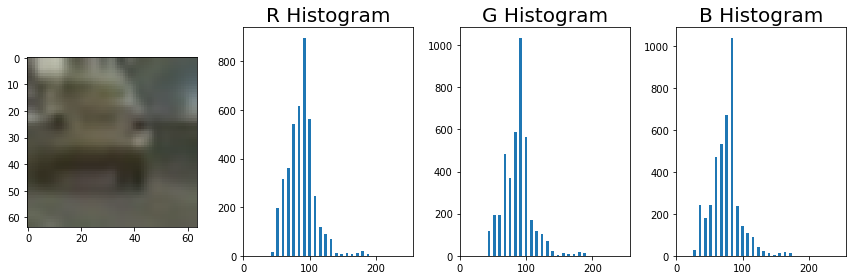

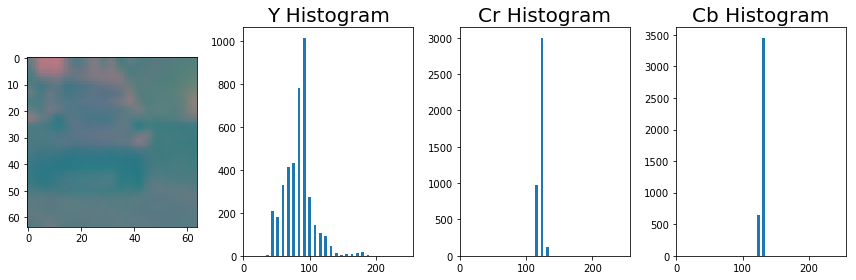

In [5]:
### Look at the different color spaces and see which provides the most data
test_img_veh = cv2.imread(cars[randint(0,2000)])
test_img_veh2 = cv2.cvtColor(test_img_veh, cv2.COLOR_BGR2YCrCb)

# Compute the histogram of the RGB channels separately
rhist = np.histogram(test_img_veh[:,:,0], bins=32, range=(0,256))
ghist = np.histogram(test_img_veh[:,:,1], bins=32, range=(0,256))
bhist = np.histogram(test_img_veh[:,:,2], bins=32, range=(0,256))

# Compute the histogram of the YCrCb channels separately (since this is the recommended color space)
yhist = np.histogram(test_img_veh2[:,:,0], bins=32, range=(0,256))
crhist = np.histogram(test_img_veh2[:,:,1], bins=32, range=(0,256))
cbhist = np.histogram(test_img_veh2[:,:,2], bins=32, range=(0,256))

# Generating bin centers
bin_edges   = yhist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Concatenate the histograms into a single feature vector
hist_features = np.concatenate((yhist[0], crhist[0], cbhist[0]))

# Plot each of the 3 channels
if ghist is not None:
    fig = plt.figure(figsize=(12,4))
    plt.subplot(141)
    plt.imshow(test_img_veh)
    plt.subplot(142)
    plt.bar(bin_centers, rhist[0], width = 4)
    plt.xlim(0, 256)
    plt.title('R Histogram',fontsize=20)
    plt.subplot(143)
    plt.bar(bin_centers, ghist[0], width = 4)
    plt.xlim(0, 256)
    plt.title('G Histogram',fontsize=20)
    plt.subplot(144)
    plt.bar(bin_centers, bhist[0], width = 4)
    plt.xlim(0, 256)
    plt.title('B Histogram',fontsize=20)
    fig.tight_layout()
    
    fig2 = plt.figure(figsize=(12,4))
    plt.subplot(141)
    plt.imshow(test_img_veh2)
    plt.subplot(142)
    plt.bar(bin_centers, yhist[0], width = 4)
    plt.xlim(0, 256)
    plt.title('Y Histogram',fontsize=20)
    plt.subplot(143)
    plt.bar(bin_centers, crhist[0], width = 4)
    plt.xlim(0, 256)
    plt.title('Cr Histogram',fontsize=20)
    plt.subplot(144)
    plt.bar(bin_centers, cbhist[0], width = 4)
    plt.xlim(0, 256)
    plt.title('Cb Histogram',fontsize=20)
    fig2.tight_layout()
    
    
else:
    print('Your function is returning None for at least one variable...')
    
# From this analysis we can see that RGB histograms are not unique, whereas YCrCb colorspace histograms appear to be

# ** Color Space Analysis **
Let's play around with the plot3d function provided 

All Done!


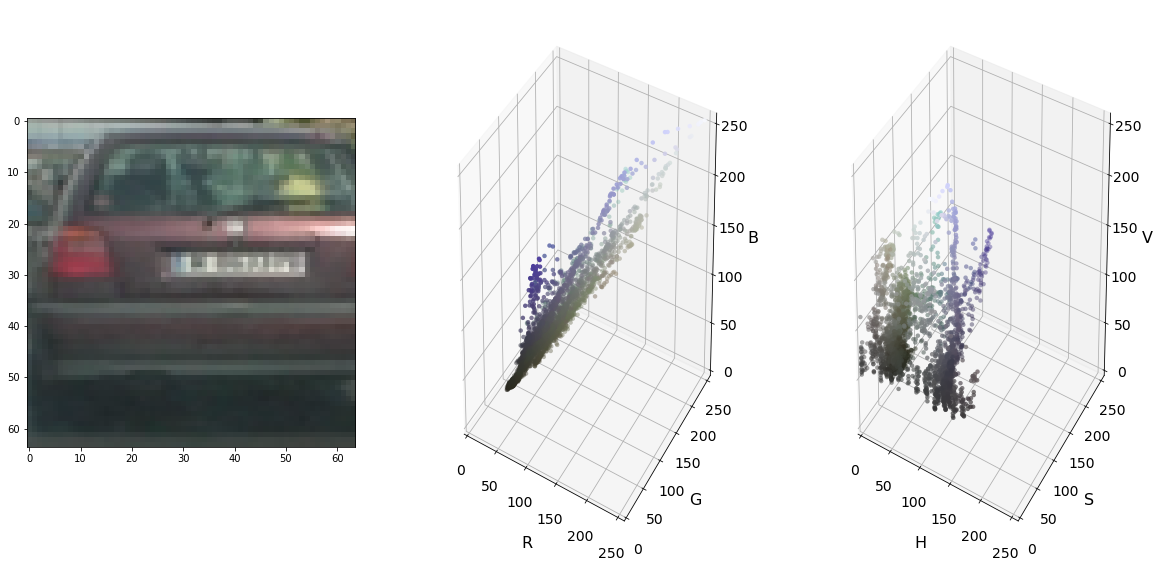

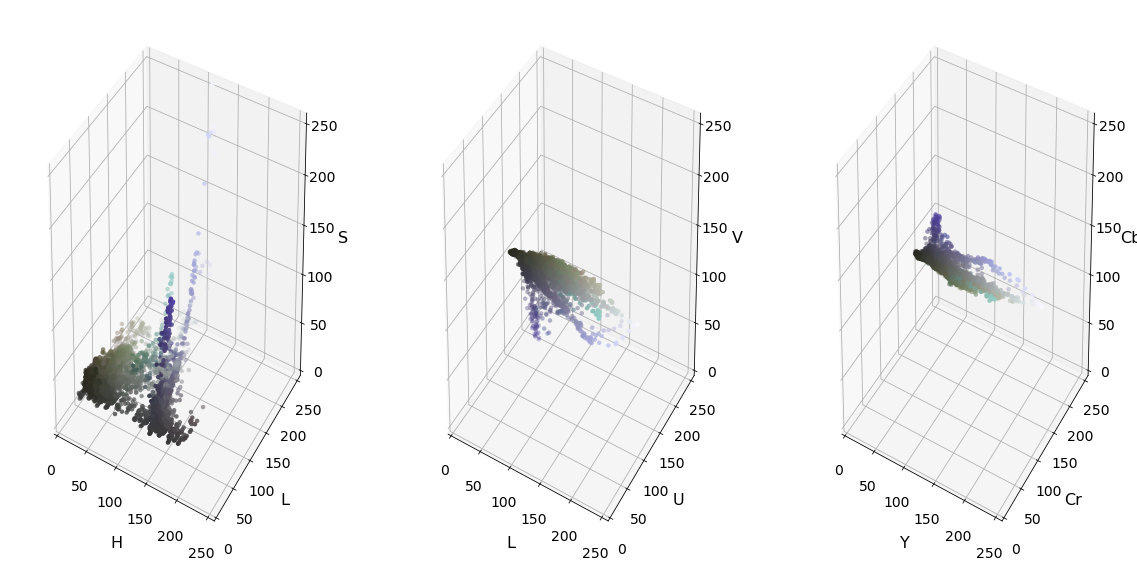

In [6]:
# Read a random car image
test_img_veh = cv2.imread(cars[randint(0,2000)])
test_img_veh = cv2.cvtColor(test_img_veh, cv2.COLOR_BGR2RGB)

# Select a small fraction of pixels to plot by subsampling it
scale = max(test_img_veh.shape[0], test_img_veh.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(test_img_veh, (np.int(test_img_veh.shape[1] / scale), np.int(test_img_veh.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB   = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV   = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS   = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV   = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_YUV   = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_rgb   = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plotting Result
f   = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(1, 3, 1)
ax1.imshow(test_img_veh)
ax2 = f.add_subplot(1, 3, 2,projection='3d')
plot3d_custom_ax(ax2,img_small_RGB, img_small_rgb, axis_labels=list("RGB"))
ax2.set_xlabel('R', fontsize=16, labelpad=16)
ax2.set_ylabel('G', fontsize=16, labelpad=16)
ax2.set_zlabel('B', fontsize=16, labelpad=16)
ax3 = f.add_subplot(1, 3, 3,projection='3d')
plot3d_custom_ax(ax3,img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
ax3.set_xlabel('H', fontsize=16, labelpad=16)
ax3.set_ylabel('S', fontsize=16, labelpad=16)
ax3.set_zlabel('V', fontsize=16, labelpad=16)

f   = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(1, 3, 1,projection='3d')
plot3d_custom_ax(ax1,img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
ax1.set_xlabel('H', fontsize=16, labelpad=16)
ax1.set_ylabel('L', fontsize=16, labelpad=16)
ax1.set_zlabel('S', fontsize=16, labelpad=16)
ax2 = f.add_subplot(1, 3, 2,projection='3d')
plot3d_custom_ax(ax2,img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
ax2.set_xlabel('L', fontsize=16, labelpad=16)
ax2.set_ylabel('U', fontsize=16, labelpad=16)
ax2.set_zlabel('V', fontsize=16, labelpad=16)
ax3 = f.add_subplot(1, 3, 3,projection='3d')
plot3d_custom_ax(ax3,img_small_YCrCb, img_small_rgb, axis_labels=list("YCrCb"))
ax3.set_xlabel('Y', fontsize=16, labelpad=16)
ax3.set_ylabel('Cr', fontsize=16, labelpad=16)
ax3.set_zlabel('Cb', fontsize=16, labelpad=16)

print("All Done!")

# ** Spatial Color Binning **
Test spatial binning of color

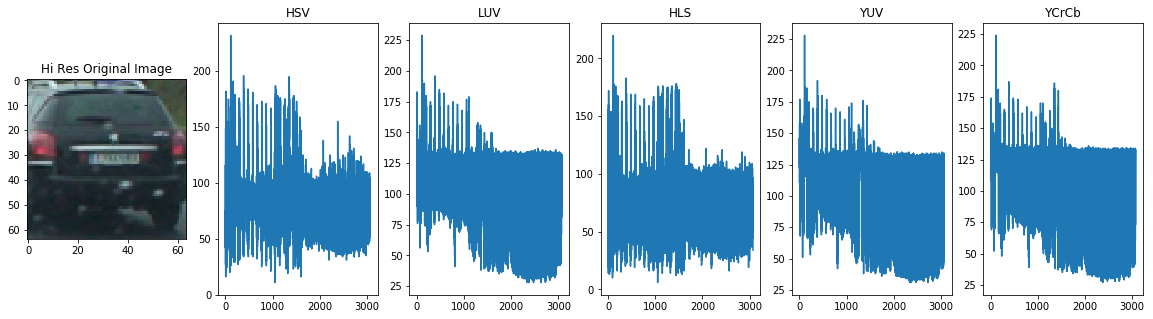

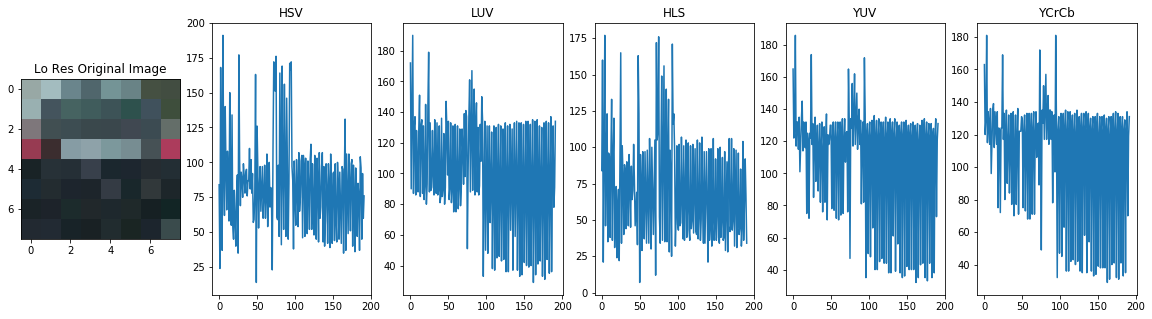

In [7]:
# Read in an image
# You can also read cutout2, 3, 4 etc. to see other examples
test_img_veh = cv2.imread(cars[randint(0,2000)])
test_img_veh = cv2.cvtColor(test_img_veh, cv2.COLOR_BGR2RGB)
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!

    
feature_vec_hsv   = test_bin_spatial(test_img_veh, color_space='HSV', size=(32, 32))
feature_vec_luv   = test_bin_spatial(test_img_veh, color_space='LUV', size=(32, 32))
feature_vec_hls   = test_bin_spatial(test_img_veh, color_space='HLS', size=(32, 32))
feature_vec_yuv   = test_bin_spatial(test_img_veh, color_space='YUV', size=(32, 32))
feature_vec_ycrcb = test_bin_spatial(test_img_veh, color_space='YCrCb', size=(32, 32))

# Plot features
fig = plt.figure(figsize=(20,5))
plt.subplot(161)
plt.imshow(test_img_veh)
plt.title('Hi Res Original Image')
plt.subplot(162)
plt.plot(feature_vec_hsv)
plt.title('HSV')
plt.subplot(163)
plt.plot(feature_vec_luv)
plt.title('LUV')
plt.subplot(164)
plt.plot(feature_vec_hls)
plt.title('HLS')
plt.subplot(165)
plt.plot(feature_vec_yuv)
plt.title('YUV')
plt.subplot(166)
plt.plot(feature_vec_ycrcb)
plt.title('YCrCb')

size = (8, 8)
small_img = cv2.resize(test_img_veh, size)

feature_vec_hsv   = test_bin_spatial(small_img, color_space='HSV',   size=size)
feature_vec_luv   = test_bin_spatial(small_img, color_space='LUV',   size=size)
feature_vec_hls   = test_bin_spatial(small_img, color_space='HLS',   size=size)
feature_vec_yuv   = test_bin_spatial(small_img, color_space='YUV',   size=size)
feature_vec_ycrcb = test_bin_spatial(small_img, color_space='YCrCb', size=size)

# Plot features
fig = plt.figure(figsize=(20,5))
plt.subplot(161)
plt.imshow(small_img)
plt.title('Lo Res Original Image')
plt.subplot(162)
plt.plot(feature_vec_hsv)
plt.title('HSV')
plt.subplot(163)
plt.plot(feature_vec_luv)
plt.title('LUV')
plt.subplot(164)
plt.plot(feature_vec_hls)
plt.title('HLS')
plt.subplot(165)
plt.plot(feature_vec_yuv)
plt.title('YUV')
plt.subplot(166)
plt.plot(feature_vec_ycrcb)
plt.title('YCrCb')

# ** Gradient Threshold Testing **
Test different methods of playing with gradients

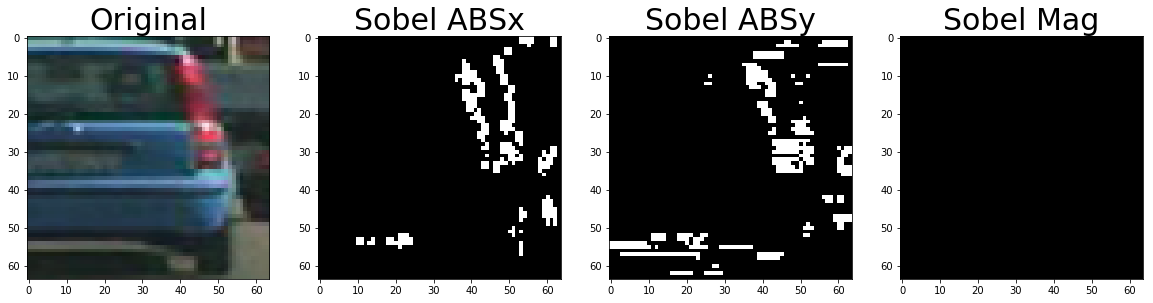

In [8]:
test_img_veh = cv2.imread(cars[randint(0,2000)])
img       = cv2.cvtColor(test_img_veh, cv2.COLOR_BGR2RGB)
img_hls   = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
img_gs    = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hls       = img_hls
gs        = img_gs
rgb       = img
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
    
color_binary = test_combined_color(rgb);
    
sobel_chan = h_channel
    
bin_out_absx = test_sobel_absx(sobel_chan,9,50,255)
bin_out_absy = test_sobel_absy(sobel_chan,9,50,255)
bin_out_mag  = test_sobel_mag(sobel_chan, 9,50,255)
bin_out_dir  = test_sobel_dir(sobel_chan, 9,0,255)
    
# Visualize Thresholded Images
plt.figure(0)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(bin_out_absx, cmap='gray')
ax2.set_title('Sobel ABSx', fontsize=30)
ax3.imshow(bin_out_absy, cmap='gray')
ax3.set_title('Sobel ABSy', fontsize=30)
ax4.imshow(bin_out_dir, cmap='gray')
ax4.set_title('Sobel Mag', fontsize=30)

# ** HOG Feature Testing **
Take a look at the visualization of HOG features on a random vehicle image

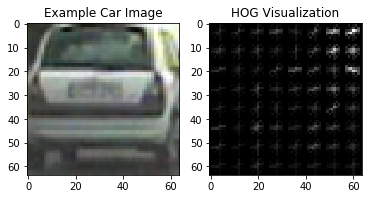

In [33]:
# Code taken from vehicle detection and tracking . 22

# Generate a random index to look at a car image
test_img_veh = cv2.imread(cars[randint(0,2000)])
img          = cv2.cvtColor(test_img_veh, cv2.COLOR_BGR2RGB)
img_ycrcb    = cv2.cvtColor(test_img_veh, cv2.COLOR_RGB2YCrCb)

features, hog_image = get_hog_features(img_ycrcb[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

# Note: this is not actually a plot of the HOG featuers, but rather a visualization of gradient directions 
# within each cell, with brightness corresponding to the strength of the gradient in that cell

## Spatial Binning and Color Histogram Testing
(No HOG Features)

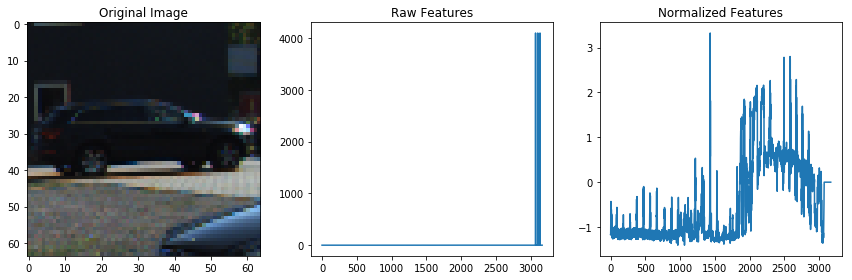

In [10]:
# Let's test the spatial binning and color histogram with scaler

# Taken from vehicle detection and tracking . 22
# Generate a random index to look at a car image
test_img_veh = cv2.imread(cars[randint(0,2000)])
#test_img_veh = cv2.cvtColor(test_img_veh, cv2.COLOR_BGR2RGB)

test_img_nonveh = cv2.imread(notcars[randint(0,2000)])
#test_img_nonveh = cv2.cvtColor(test_img_nonveh, cv2.COLOR_BGR2RGB)


car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        hog_orient=9, hog_pixpcell=8, hog_cellpblock=2,hog_ch=2,
                        add_spatial = True, add_hist = True, add_HOG = False)

notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        hog_orient=9, hog_pixpcell=8, hog_cellpblock=2,hog_ch=2,
                        add_spatial = True, add_hist = True, add_HOG = False)


if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)    
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(imgs_veh))
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## Spatial Binning, Color Histogram and HOG Testing

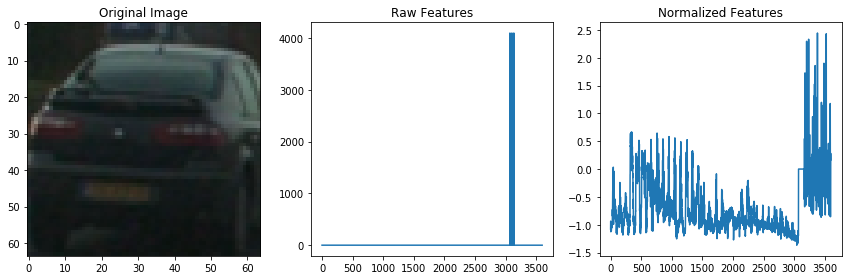

In [11]:
car_features_hog = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        hog_orient=9, hog_pixpcell=8, hog_cellpblock=2,hog_ch='ALL',
                        add_spatial = True, add_hist = True, add_HOG = True)

notcar_features_hog = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        hog_orient=9, hog_pixpcell=8, hog_cellpblock=2,hog_ch='ALL',
                        add_spatial = True, add_hist = True, add_HOG = True)

if len(car_features_hog) > 0:
    # Create an array stack of feature vectors
    X_hog = np.vstack((car_features_hog, notcar_features_hog)).astype(np.float64)                        
    
    # Fit a per-column scaler
    X_hog_scaler = StandardScaler().fit(X_hog)
    
    # Apply the scaler to X
    scaled_X_hog = X_hog_scaler.transform(X_hog)
    car_ind = np.random.randint(0, len(imgs_veh))
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X_hog[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X_hog[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

# ** Linear SVC Training **

In [12]:
scaled_X,y = prep_data_training(car_features,notcar_features)

X_train, X_test, y_train, y_test = split_data(scaled_X,y)

Train_LinearSVC(X_train,y_train,X_test,y_test)

scaled_X.shape: (17760, 3168)
y.shape:        (17760,)
X_train shape: (14208, 3168)
X_test  shape: (3552, 3168)
y_train shape: (14208,)
y_test  shape: (3552,)
It took  41.36 seconds to train
Test Accuracy: 90.9910%
  Predictions: [ 0.  1.  1.  1.  0.  0.  0.  1.  0.  1.]
       Labels: [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]


In [13]:
scaled_X_hog,y_hog = prep_data_training(car_features_hog,notcar_features_hog)
Xhog_train, Xhog_test, yhog_train, yhog_test = split_data(scaled_X_hog,y_hog)

Train_LinearSVC(Xhog_train,yhog_train,Xhog_test,yhog_test)


# we can see that the hog features do much better and that we should use them

scaled_X.shape: (17760, 3600)
y.shape:        (17760,)
X_train shape: (14208, 3600)
X_test  shape: (3552, 3600)
y_train shape: (14208,)
y_test  shape: (3552,)
It took  15.98 seconds to train
Test Accuracy: 96.3964%
  Predictions: [ 1.  1.  0.  1.  1.  1.  1.  0.  1.  1.]
       Labels: [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]


# ** Sliding Window Function Check **

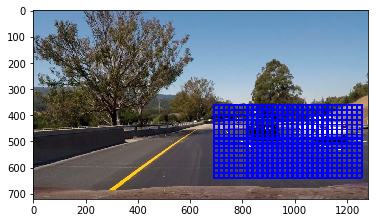

In [36]:
# test the sliding of windows around

test_img = mpimg.imread(imgs_test[2])
windows = slide_window(test_img, x_start_stop=[690, 1270], y_start_stop=[360, 648], 
                        xy_window=(128, 128), xy_overlap=(0.85, 0.85))
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

# things look like they're working fine

# ** Searching and Classifying**

In [15]:
# It's time to actually do stuff!
# Let's train a classifier


### Taken from vehicle detection and tracking . 34 ###


### TODO: Tweak these parameters and see how the results change.
color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9          # HOG orientations
pix_per_cell   = 16         # HOG pixels per cell
cell_per_block = 4          # HOG cells per block
hog_channel    = "ALL"      # Can be 0, 1, 2, or "ALL"
spatial_size   = (16, 16)   # Spatial binning dimensions
hist_bins      = 16         # Number of histogram bins
spatial_feat   = True       # Spatial features on or off
hist_feat      = True       # Histogram features on or off
hog_feat       = True       # HOG features on or off
y_start_stop   = [400, 640] # Min and max in y to search in slide_window()

car_features = extract_features(cars, cspace = color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, hist_range=(0, 256),
                     hog_orient = orient, hog_pixpcell=pix_per_cell, hog_cellpblock=cell_per_block,hog_ch=hog_channel,
                     add_spatial = spatial_feat, add_hist = hist_feat, add_HOG = hog_feat)
    
notcar_features = extract_features(notcars, cspace = color_space, spatial_size=spatial_size,
                     hist_bins=hist_bins, hist_range=(0, 256),
                     hog_orient= orient, hog_pixpcell=pix_per_cell, hog_cellpblock=cell_per_block,hog_ch=hog_channel,
                     add_spatial = spatial_feat, add_hist = hist_feat, add_HOG = hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.25, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=0.01)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 16 pixels per cell and 4 cells per block
Feature vector length: 1248
2.59 Seconds to train SVC...
Test Accuracy of SVC =  0.9809


In [16]:
# Save Classifier to Pickle File
classifier_pickle = {}
classifier_pickle["svc"] = svc
classifier_pickle["X_scaler"] = X_scaler
classifier_pickle["scaled_X"] = scaled_X
pickle.dump(classifier_pickle, open("output_images/Classifier.p", "wb"));
print('Saved pickle file with Classifier')

Saved pickle file with Classifier


# **Draw All Bounding Boxes **

Saved pickle file with bboxes
Saved pickle file with bboxes
Saved pickle file with bboxes
Saved pickle file with bboxes
Saved pickle file with bboxes
Saved pickle file with bboxes


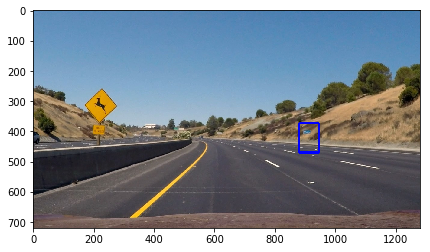

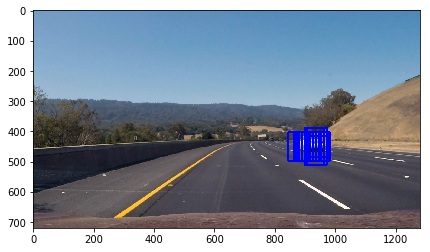

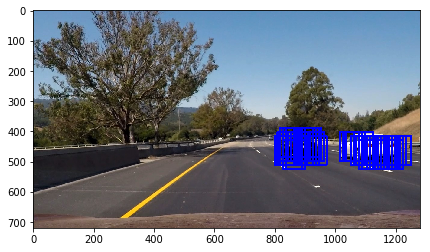

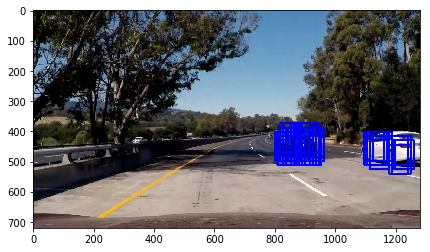

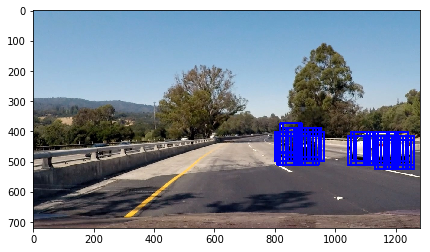

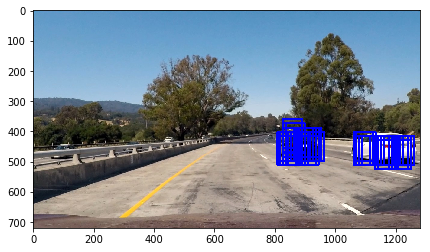

In [17]:
# draw all bounding boxes before application of heat map on test images

for idx, fname in enumerate(imgs_test):
    image = mpimg.imread(imgs_test[idx])
    window_img, hot_windows = test_single_image(image)
    
    
    bbox_pickle = {}
    all_bboxes = hot_windows
    bbox_pickle["bboxes"] = all_bboxes
    pickle_str = 'output_images/bbox_pickle_' + str(idx) + ".p"
    pickle.dump(bbox_pickle, open(pickle_str, "wb"));
    print('Saved pickle file with bboxes')
    
    
    plt.figure(idx) 
    # Visualize Output
    fig = plt.figure(figsize=(12,4))
    plt.imshow(window_img)

# **Draw Single Bounding Box and Heatmap **

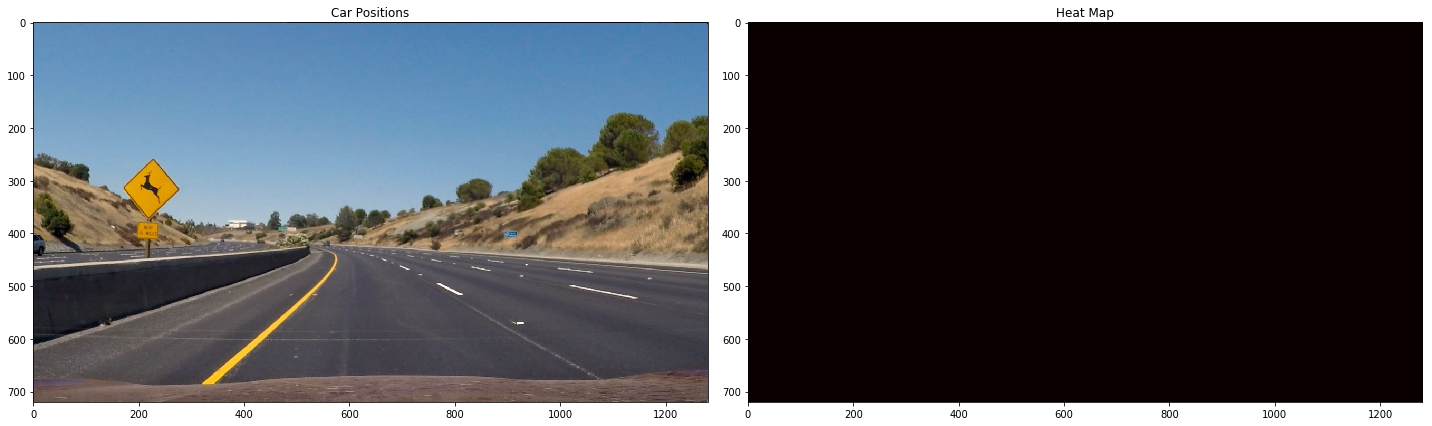

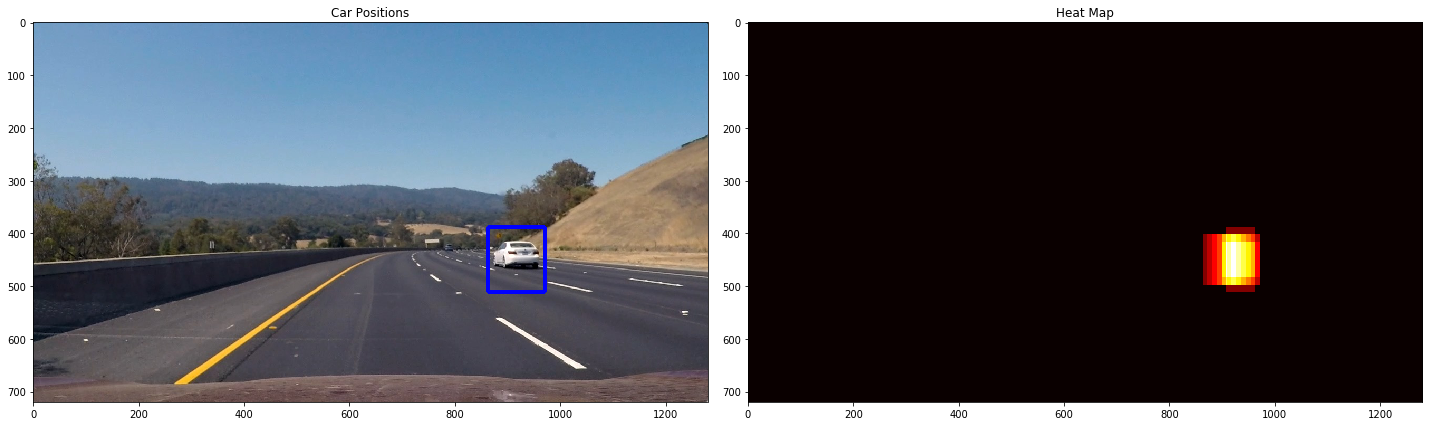

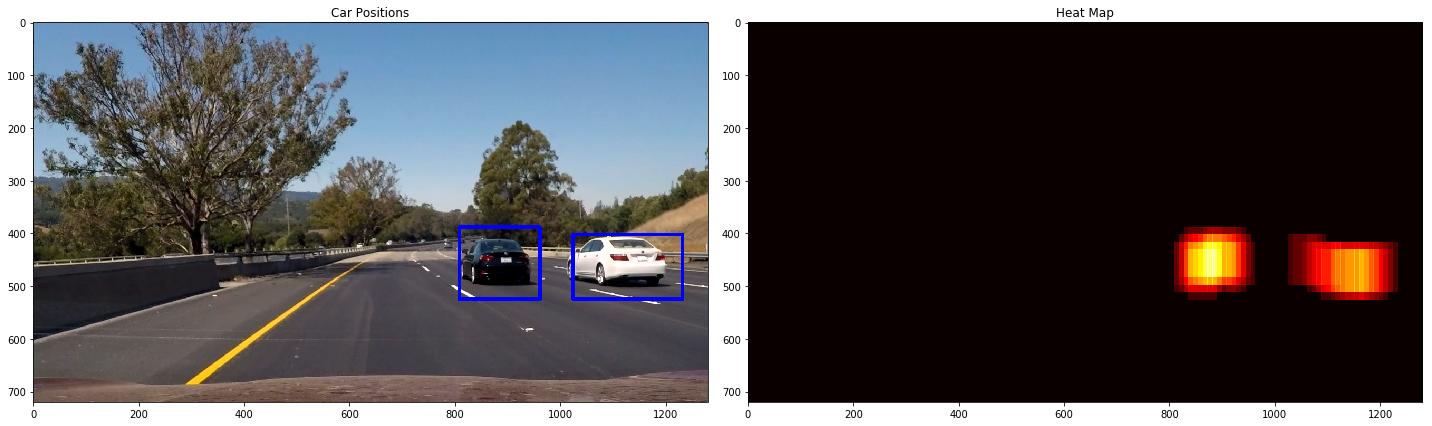

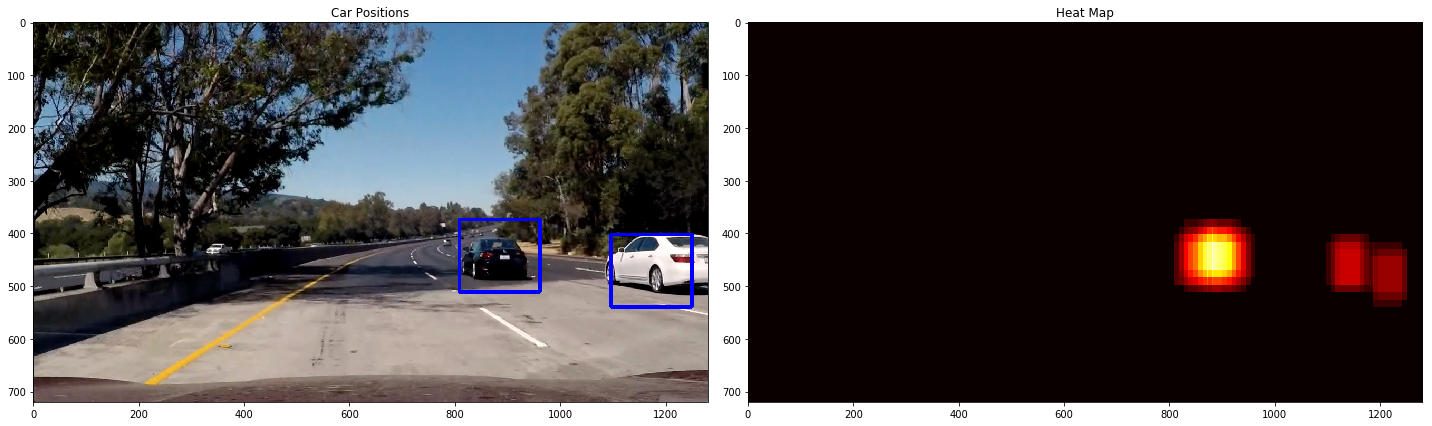

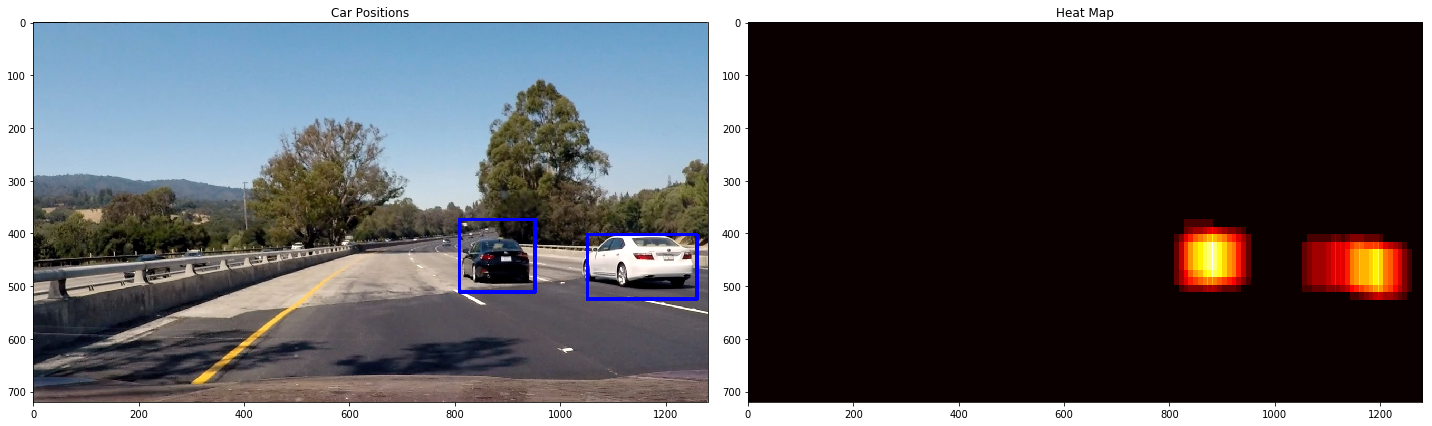

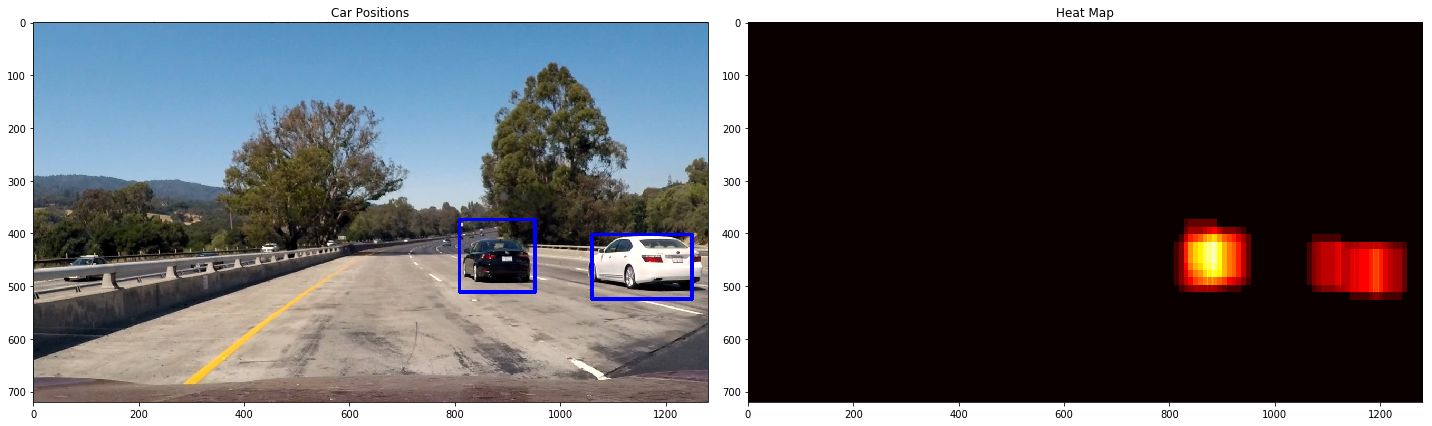

In [18]:
# draw averaged bounding boxes and heatmap for test images
for idx, fname in enumerate(imgs_test):
    fig = plt.figure(figsize=(20,20))
    heatmap,draw_img,labels = test_heatmap(idx)
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

# ** Vehicle Detection and Tracking on Video **

In [19]:
video_output = 'output_project_video.mp4'
clip = VideoFileClip('project_video.mp4')#.subclip(19,20)

output_clip = clip.fl_image(video_pipeline) #color images only
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [1:00:16<00:02,  2.84s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 58min 23s, sys: 1min 33s, total: 59min 57s
Wall time: 1h 17s
